In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 11.1 MB/s 
     |████████████████████████████████| 3.5 MB 10.4 MB/s 


In [ ]:
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print(data)
## outputs:
# Dataset: CiteSeer():
# ======================
# Number of graphs: 1
# Number of features: 3703
# Number of classes: 6
# Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327],val_mask=[3327], test_mask=[3327])


Processing...


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


Done!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## Q1


In [ ]:
###Q1
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch_geometric.nn.GCNConv(3703,64)
        self.conv2 = torch_geometric.nn.GCNConv(64,64)
        self.fc1 = nn.Linear(64, 6)
        self.var = 0
        self.ans = 0


    def forward(self,x, e):
        x = F.relu(self.conv1(x,e));

        x = self.conv2(x,e)
        self.var = x
        x = self.fc1(x)
        self.ans = F.log_softmax(x, dim=1)
        return F.log_softmax(x, dim=1)
    def embedded(self):
      return [self.var, self.ans]


net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): GCNConv(3703, 64)
  (conv2): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:

def train():
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
  totalloss = 0
  for data in dataset:
    data.to(device)
    optimizer.zero_grad()
    inputfeature = data.x
    label = data.y
    output = net(inputfeature, data.edge_index)


    loss = F.nll_loss(output[data.train_mask], label[data.train_mask])
    loss.backward()
    optimizer.step()
    totalloss += loss.item()
  return totalloss


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
# emb: (nNodes, hidden_dim)
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
def visualize(emb: torch.tensor, node_type: torch.tensor):
  z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
  plt.figure(figsize=(10,10))
  plt.scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


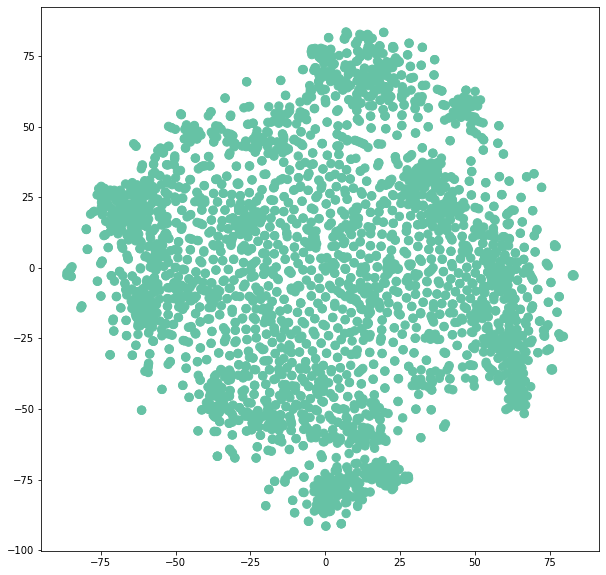

In [ ]:
epochs = [i for i in range (1, 201)]
trainclasslosslist = []
trainclasserrorlist = []
testclasserrorlist=[]

for epoch in range (200):
  train()

  trainclasserror = 0
  trainloss = 0
  for data in dataset:
    data.to(device)
    output = net(data.x, data.edge_index)
    output1 = output[data.train_mask]
    label1 = data.y[data.train_mask]
    err = 0
    for i in range (label1.shape[0]):
      otpl = output1[i].tolist()
      pred = otpl.index(max(otpl))
      if pred != label1[i]:
          err=err+1
    err = err/ label1.shape[0]
    trainclasserror += err

    lossfn = nn.CrossEntropyLoss()
    losing = lossfn(output1, label1).item()
    trainloss = trainloss+losing

  trainclasserror = trainclasserror / len(dataset)
  trainloss = trainloss / len(dataset)

  testclasserror = 0
  for data in dataset:
    data.to(device)
    output = net(data.x, data.edge_index)
    output1 = output[data.test_mask]
    label1 = data.y[data.test_mask]
    err = 0
    for i in range (label1.shape[0]):
      otpl = output1[i].tolist()
      pred = otpl.index(max(otpl))
      if pred != label1[i]:
          err=err+1
    err = err/ label1.shape[0]
    testclasserror += err
  testclasserror = testclasserror / len(dataset)
  trainclasslosslist.append(trainloss)
  trainclasserrorlist.append(trainclasserror)
  testclasserrorlist.append(testclasserror)

  if epoch==0:
    nump = net.embedded()[1].to(torch.device("cpu")).detach().numpy()
    n= np.zeros(nump.shape[0])
    for i in range (nump.shape[0]):
      alist = nump[i].tolist()
      ans = alist.index(max(alist))
      n[i] = ans

    visualize(net.embedded()[0].to(torch.device("cpu")), n)


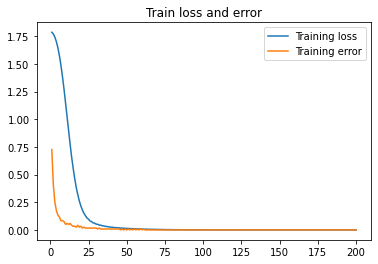

In [ ]:
##Trainingloss
plt.plot(epochs, trainclasslosslist,label='Training loss')
plt.plot(epochs, trainclasserrorlist,label='Training error')
plt.title("Train loss and error")
plt.legend()
plt.show()

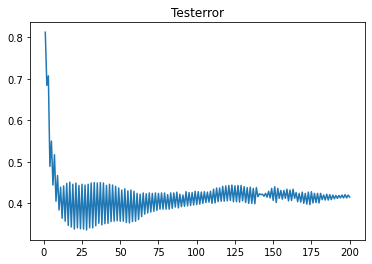

In [ ]:
##Testerrr
plt.plot(epochs, testclasserrorlist)
plt.title("Testerror")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


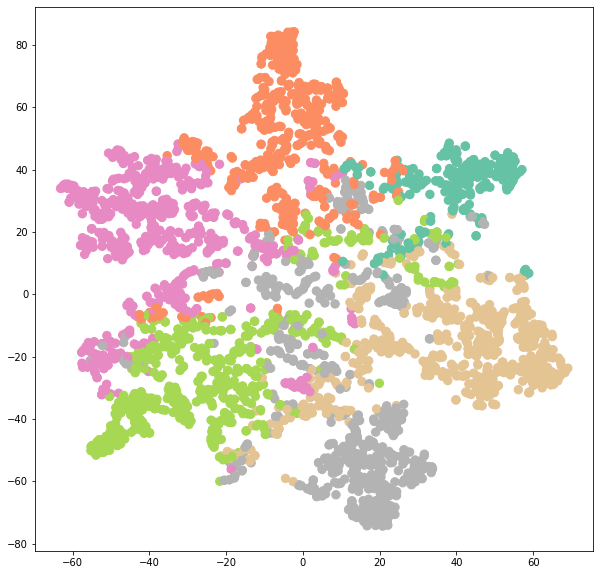

In [ ]:
nump = net.embedded()[1].to(torch.device("cpu")).detach().numpy()
n= np.zeros(nump.shape[0])
for i in range (nump.shape[0]):
  alist = nump[i].tolist()
  ans = alist.index(max(alist))
  n[i] = ans

visualize(net.embedded()[0].to(torch.device("cpu")), n)

### Q2

In [ ]:
###Q2######
from torch_geometric.nn import GCNConv
from torch.nn import ReLU, Sequential
model = Sequential(nn.Linear(3703, 64), ReLU(),nn.Linear(64, 64), ReLU())
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch_geometric.nn.GINConv(model)
        self.fc1 = nn.Linear(64, 6)
        self.var = 0
        self.ans = 0


    def forward(self,x, e):

        x = self.conv1(x,e)
        self.var = x
        x = self.fc1(x)
        self.ans = F.log_softmax(x, dim=1)
        return F.log_softmax(x, dim=1)
    def embedded(self):
      return [self.var, self.ans]


net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
##data=dataset[0]
##data.to(device)
##output = net(data.x, data.edge_index)
##print(output)

tensor([[-1.8038, -1.8756, -1.6970, -1.7417, -1.7893, -1.8545],
        [-1.8037, -1.8766, -1.6958, -1.7415, -1.7898, -1.8546],
        [-1.8044, -1.8761, -1.6956, -1.7421, -1.7890, -1.8549],
        ...,
        [-1.8047, -1.8764, -1.6955, -1.7418, -1.7894, -1.8543],
        [-1.8045, -1.8762, -1.6941, -1.7422, -1.7907, -1.8545],
        [-1.8046, -1.8757, -1.6964, -1.7422, -1.7887, -1.8544]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


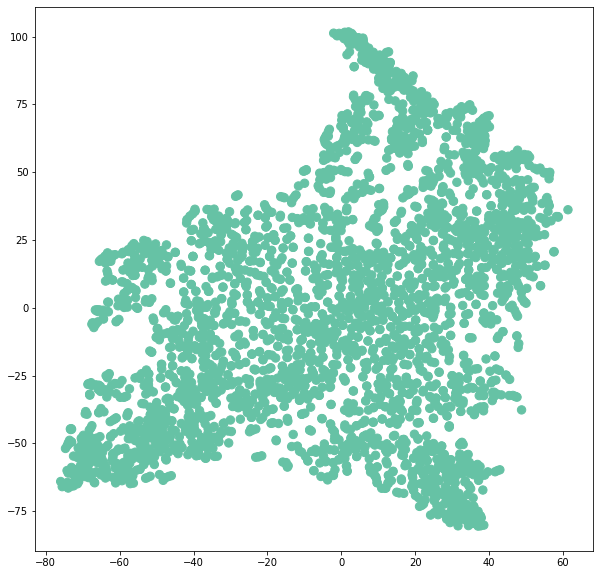

In [ ]:
epochs = [i for i in range (1, 201)]
trainclasslosslist = []
trainclasserrorlist = []
testclasserrorlist=[]

for epoch in range (200):
  train()

  trainclasserror = 0
  trainloss = 0
  for data in dataset:
    data.to(device)
    output = net(data.x, data.edge_index)
    output1 = output[data.train_mask]
    label1 = data.y[data.train_mask]
    err = 0
    for i in range (label1.shape[0]):
      otpl = output1[i].tolist()
      pred = otpl.index(max(otpl))
      if pred != label1[i]:
          err=err+1
    err = err/ label1.shape[0]
    trainclasserror += err

    lossfn = nn.CrossEntropyLoss()
    losing = lossfn(output1, label1).item()
    trainloss = trainloss+losing

  trainclasserror = trainclasserror / len(dataset)
  trainloss = trainloss / len(dataset)

  testclasserror = 0
  for data in dataset:
    data.to(device)
    output = net(data.x, data.edge_index)
    output1 = output[data.test_mask]
    label1 = data.y[data.test_mask]
    err = 0
    for i in range (label1.shape[0]):
      otpl = output1[i].tolist()
      pred = otpl.index(max(otpl))
      if pred != label1[i]:
          err=err+1
    err = err/ label1.shape[0]
    testclasserror += err
  testclasserror = testclasserror / len(dataset)
  trainclasslosslist.append(trainloss)
  trainclasserrorlist.append(trainclasserror)
  testclasserrorlist.append(testclasserror)

  if epoch==0:
    nump = net.embedded()[1].to(torch.device("cpu")).detach().numpy()
    n= np.zeros(nump.shape[0])
    for i in range (nump.shape[0]):
      alist = nump[i].tolist()
      ans = alist.index(max(alist))
      n[i] = ans

    visualize(net.embedded()[0].to(torch.device("cpu")), n)


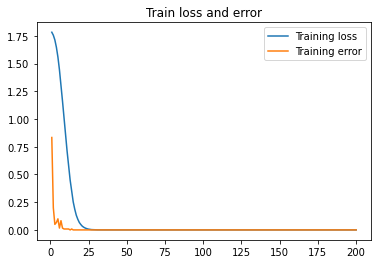

In [ ]:
##Trainingloss
plt.plot(epochs, trainclasslosslist,label='Training loss')
plt.plot(epochs, trainclasserrorlist,label='Training error')
plt.title("Train loss and error")
plt.legend()
plt.show()

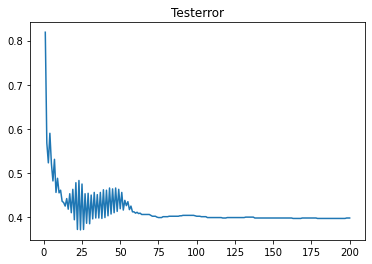

In [ ]:
##Testerrr
plt.plot(epochs, testclasserrorlist)
plt.title("Testerror")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


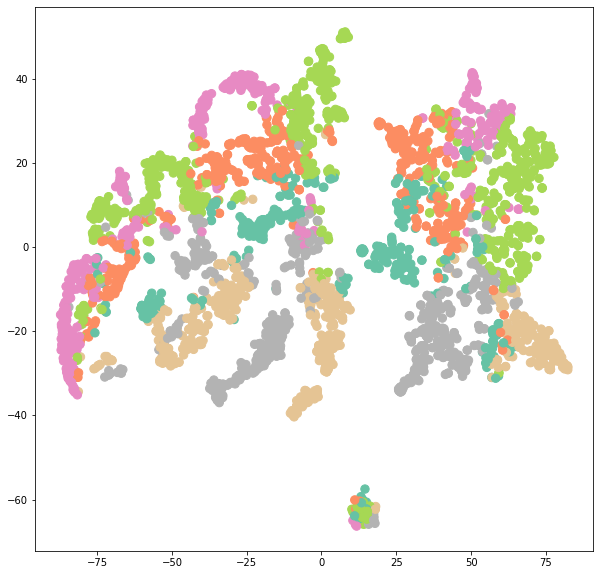

In [ ]:
nump = net.embedded()[1].to(torch.device("cpu")).detach().numpy()
n= np.zeros(nump.shape[0])
for i in range (nump.shape[0]):
  alist = nump[i].tolist()
  ans = alist.index(max(alist))
  n[i] = ans

visualize(net.embedded()[0].to(torch.device("cpu")), n)

### Q3

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
# dataset = KarateClub(transform=NormalizeFeatures())
dataset = TUDataset(root='data/TUDataset', name='MUTAG',
transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
train_dataset = dataset[: int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8): ]
print('==== train_dataset =====')
print(train_dataset)
print('==== test_dataset =====')
print(test_dataset)

Extracting data/TUDataset/MUTAG/MUTAG.zip


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
==== train_dataset =====
MUTAG(150)
==== test_dataset =====
MUTAG(38)


Processing...
Done!


In [ ]:

maxy = 0
for data in dataset:
  data.to(device)
  xv = data.x.shape[0]

  if xv>maxy:
    maxy = xv
print(maxy)
data=dataset[0]
data.to(device)

28


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [ ]:
###Q3######
from torch_geometric.nn import GCNConv
from torch.nn import ReLU, Sequential
model = Sequential(nn.Linear(7, 64), nn.BatchNorm1d(64),ReLU(),nn.Linear(64, 64),nn.BatchNorm1d(64),ReLU())
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch_geometric.nn.GINConv(model)
        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(28, 1)
        self.dp1 = nn.Dropout(p=0.5)
    def forward(self,x, edge_index):

        x = self.conv1(x,edge_index)
        x = self.dp1(x)
        x = self.fc1(x)

        padding = maxy - x.shape[0]
        x=x.flatten()

        x  = torch.nn.functional.pad(x, (0, padding))
        x = self.fc2(x)

        return x



net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
net(data.x, data.edge_index)

In [ ]:
import math
def train():
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
  totalloss = 0
  for data in train_dataset:
    data.to(device)
    optimizer.zero_grad()

    label = data.y
    if label[0]==0:
      label[0] = -1
    output = net(data.x, data.edge_index)

    lossfn = nn.L1Loss(reduction = 'sum')
    loss = lossfn(output, label)

    loss.backward()
    optimizer.step()

    totalloss += loss.item()
  return totalloss


In [ ]:
net = Net()
net.to(device)
epochs = [i for i in range (1, 31)]
trainclasserrorlist = []
trainclasslosslist = []
testclasserrorlist=[]
testclasslosslist = []
for epoch in range (30):
  train()

  trainclasserror = 0
  trainclassloss = 0
  for data in train_dataset:
    data.to(device)
    output = net(data.x, data.edge_index)[0]

    label = data.y
    if label[0]==0:
      label[0] = -1
    if (label[0]*output<0):
      trainclasserror=trainclasserror+1
    trainclassloss = trainclassloss+abs(label[0].item()-output.item())


  trainclasserror = trainclasserror / len(train_dataset)
  trainclassloss = trainclassloss / len(train_dataset)

  testclassloss = 0
  testclasserror = 0
  for data in test_dataset:
    data.to(device)
    output = net(data.x, data.edge_index)[0]

    label = data.y
    if label[0]==0:
      label[0] = -1
    if (label[0]*output<0):
      testclasserror=testclasserror+1
    testclassloss = testclasserror+abs(label[0].item()-output.item())



  testclasserror = testclasserror / len(test_dataset)
  testclassloss = testclassloss / len(test_dataset)

  trainclasserrorlist.append(trainclasserror)
  trainclasslosslist.append(trainclassloss)
  testclasserrorlist.append(testclasserror)
  testclasslosslist.append(testclassloss)

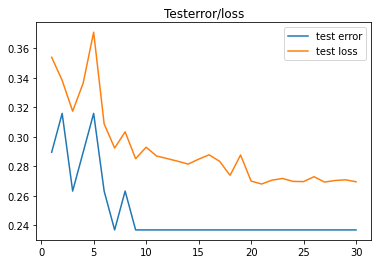

In [ ]:
##Testerrr
plt.plot(epochs, testclasserrorlist, label = "test error")
plt.plot(epochs, testclasslosslist, label = "test loss")
plt.title("Testerror/loss")
plt.legend()
plt.show()

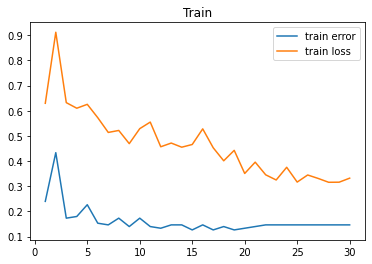

In [ ]:
plt.plot(epochs, trainclasserrorlist, label = "train error")
plt.plot(epochs, trainclasslosslist, label = "train loss")
plt.title("Train")
plt.legend()
plt.show()

### Q4

In [ ]:
###Q4######
from torch_geometric.nn import GCNConv
from torch.nn import ReLU, Sequential
model = Sequential(nn.Linear(7, 64), nn.BatchNorm1d(64),ReLU(),nn.Linear(64, 64),nn.BatchNorm1d(64),ReLU())
class Net(nn.Module):

    def __init__(self, param):
        super(Net, self).__init__()
        self.param = param
        self.conv1 = torch_geometric.nn.GINConv(model)
        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(28, param)
        self.dp1 = nn.Dropout(p=0.5)
    def forward(self,x, edge_index):

        x = self.conv1(x,edge_index)
        x = self.dp1(x)
        x = self.fc1(x)

        padding = 28 - x.shape[0]
        x=x.flatten()

        x  = torch.nn.functional.pad(x, (0, padding))
        x = self.fc2(x)
        #print(x)
        return x



net = Net(4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  ))
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (fc2): Linear(in_features=28, out_features=4, bias=True)
  (dp1): Dropout(p=0.5, inplace=False)
)

In [ ]:
def train():
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
  totalloss = 0
  for data in enumerate(train_loader):
    #print(data)
    optimizer.zero_grad()

    label = data[1].y
    for i in range (label.shape[0]):
      if label[i]==0:
        label[i] = -1
    data[1].x = data[1].x.to(device)
    data[1].edge_index = data[1].edge_index.to(device)

    output = net(data[1].x, data[1].edge_index)
    output = output.to(device)
    label=label.to(device)
    lossfn = nn.L1Loss()

    #print("output", output)
    #print("label", label)
    if output.shape == label.shape:
      loss = lossfn(output, label)

      loss.backward()
      optimizer.step()

    totalloss += loss.item()
  return totalloss


In [ ]:
for i, data in enumerate(train_loader):
  print(data)
  #if i>30:
    #break

In [ ]:
from torch_geometric.loader import DataLoader as dataLoader



In [ ]:
batchsizes = [4, 8, 16]
tt=[]
for batchsize in batchsizes:
  train_loader = dataLoader(train_dataset, batchsize, shuffle=True)
  test_loader = dataLoader(test_dataset, batchsize, shuffle=False)
  net = Net(batchsize)
  net.to(device)
  epochs = [i for i in range (1, 31)]
  trainclasserrorlist = []
  trainclasslosslist = []
  testclasserrorlist=[]
  testclasslosslist = []
  for epoch in range (30):
    train()

    trainclasserror = 0
    trainclassloss = 0
    for data in enumerate(train_loader):

      output = net(data[1].x.to(device), data[1].edge_index.to(device))

      label = data[1].y
      for i in range (label.shape[0]):
        if (label[i]*output[i]<0):
          trainclasserror=trainclasserror+1
        trainclassloss = trainclassloss+abs(label[i].item()-output[i].item())



    trainclasserror = trainclasserror / len(train_dataset)
    trainclassloss = trainclassloss / len(train_dataset)

    testclasserror = 0
    testclassloss = 0
    for data in enumerate(test_loader):

      output = net(data[1].x.to(device), data[1].edge_index.to(device))

      label = data[1].y
      for i in range (label.shape[0]):
        if (label[i]*output[i]<0):
          testclasserror=testclasserror+1
        testclassloss = testclassloss+abs(label[i].item()-output[i].item())



    testclasserror = testclasserror / len(test_dataset)
    testclassloss = testclassloss / len(test_dataset)

    trainclasserrorlist.append(trainclasserror)
    trainclasslosslist.append(trainclassloss)
    testclasserrorlist.append(testclasserror)
    testclasslosslist.append(testclassloss)
  tlist = [trainclasserrorlist,trainclasslosslist,testclasserrorlist,testclasslosslist]
  tt.append(tlist)




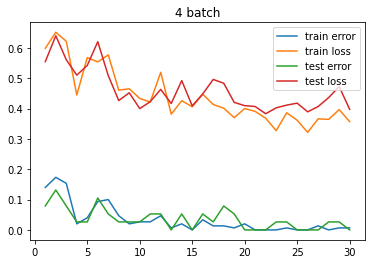

In [ ]:
plt.plot(epochs, tt[0][0], label = "train error")
plt.plot(epochs, tt[0][1], label = "train loss")

plt.plot(epochs, tt[0][2], label = "test error")
plt.plot(epochs, tt[0][3], label = "test loss")
plt.title("4 batch")
plt.legend()
plt.show()


8 batch


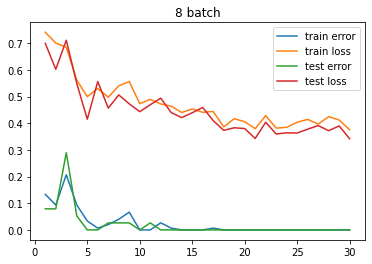

In [ ]:
plt.plot(epochs, tt[1][0], label = "train error")
plt.plot(epochs, tt[1][1], label = "train loss")

plt.plot(epochs, tt[1][2], label = "test error")
plt.plot(epochs, tt[1][3], label = "test loss")
plt.title("8 batch")
plt.legend()
plt.show()

16 batch


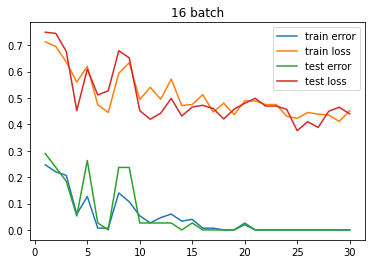

In [ ]:
plt.plot(epochs, tt[2][0], label = "train error")
plt.plot(epochs, tt[2][1], label = "train loss")

plt.plot(epochs, tt[2][2], label = "test error")
plt.plot(epochs, tt[2][3], label = "test loss")
plt.title("16 batch")
plt.legend()
plt.show()